In [1]:
# tests for points routines
# 2018/12/11 from test documentation for points module,
# most is removed. This investigates rotation of 2D arrays in order
# to develop correct 2D rotation functions.

# original notes (?not sure what was removed and what was not incorporated ever):
# sphinx
# kernel must be reset and output cleared before use or before running
# sphinx (unless you know what you are doing).

## TODO 
# - sphinxuse _build for intermediate files (move to docs\_build)
# but save output in docs(or move it there).
# - hide parts of code, add doc string above commands.
# - save the results in the noteook (this anyway will prevent 
#   future executions, so maybe make a copy or a script to clear output
#   when sphinx is called).

%reset
%load_ext autoreload
%autoreload 2

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

#from pySurf.points import *
import os
import logging
import pdb

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [16]:
from IPython.display import display
from astropy.io import fits

from dataIO.fn_add_subfix import fn_add_subfix
from dataIO.span import span, span_from_pixels
from dataIO.outliers import remove_outliers
from dataIO.functions import strip_kw,pop_kw

from scipy import ndimage
from scipy.ndimage import map_coordinates
from scipy import interpolate as ip

from plotting.captions import legendbox
from plotting.add_clickable_markers import add_clickable_markers2

from pySurf.testSurfaces import make_prof_legendre, make_surf_legendre
from pySurf.points import points_in_poly
from pySurf.find_internal_rectangle import find_internal_rectangle

from pySurf.data2D import plot_data

In [11]:
#avoid the annoying inline figures 
%matplotlib qt 

from IPython.display import display
plt.ioff()

In [12]:
#%qtconsole
plt.close('all')

In [13]:
%qtconsole

In [53]:
def test_rotate(a,rotang):
    """rotate a shape of a given angle with resample flag on and off, compare results.
    This is needed to understand how to handle axis in implementing rotation in data2D (data with axis).
    Note that rotation happens on pixels and it is mapped to pixels, so it is always integer."""
    plt.close('all')
    
    nx,ny = a.shape

    ax1=plt.subplot(311)
    plt.imshow(a);plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
    plt.colorbar()

    ax2=plt.subplot(312)
    a2=ndimage.rotate(a,rotang,reshape=0)
    plt.imshow(a2)
    plt.title("reshape=0; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%
    (plt.xlim()+plt.ylim()))
    plt.colorbar()

    ax3=plt.subplot(313)
    a3=ndimage.rotate(a,rotang,reshape=1)
    plt.imshow(a3)
    plt.title("reshape=1; xlim: %.2f:%.2f,ylim: %.2f:%.2f"
    %(plt.xlim()+plt.ylim()))
    plt.colorbar()
    plt.tight_layout(rect=[0,0,1,0.95])

    plt.suptitle("expected projected side lengths %.3f, %.3f"%(nx*np.cos(rotang*np.pi/180)+ny*np.sin(15*np.pi/180),ny*np.cos(rotang*np.pi/180)+nx*np.sin(rotang*np.pi/180)))
    
    return ax1,ax2,ax3



Use `scipy.ndimage.interpolation.rotate` with different options.
Original data (top) is a yellow rectangle of 2's in a rectangle of 1's.
When image is rotated, 0 is used as fill value for points out of the original image.
`reshape` controls if the rotated data are cropped after rotation to match original range (`shape = False`).

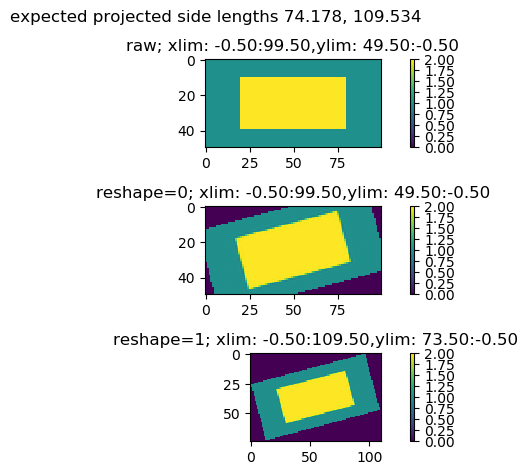

In [54]:
a=np.ones(5000).reshape((50,100))
a[10:-10,20:-20]=2
rotang=15 # rotation angle in degrees

axes=test_rotate(a,rotang)
for ax in axes:
    plt.sca(ax)
    plt.clim([0,2])
display(plt.gcf())

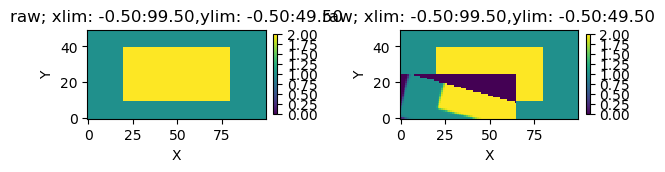

In [43]:
def rot01(img, angle, pivot):
    from scipy import ndimage
    # https://www.programcreek.com/python/example/93921/scipy.ndimage.rotate
    # ex. nr. 1
    pivot = np.array(pivot).astype(np.int32)
    # double size of image while centering object
    pads = [[img.shape[0] - pivot[0], pivot[0]], [img.shape[1] - pivot[1], pivot[1]]]
    if len(img.shape) > 2:
        pads.append([0, 0])
    imgP = np.pad(img, pads, 'constant')
    # reduce size of matrix to rotate around the object
    if len(img.shape) > 2:
        total_y = np.sum(imgP.any(axis=(0, 2))) * 2.4
        total_x = np.sum(imgP.any(axis=(1, 2))) * 2.4
    else:
        total_y = np.sum(imgP.any(axis=0)) * 2.4
        total_x = np.sum(imgP.any(axis=1)) * 2.4
    cropy = int((imgP.shape[0] - total_y)/2)
    cropx = int((imgP.shape[1] - total_x)/2)
    imgP[cropy:-cropy, cropx:-cropx] = \
        ndimage.rotate(imgP[cropy:-cropy, cropx:-cropx], angle,
        reshape=False, prefilter=False)

    return imgP[pads[0][0]: -pads[0][1], pads[1][0]: -pads[1][1]] 


#from pySurf.instrumentReader import points_reader

#infolder=r'test\input_data\profilometer\04_test_directions'
#infile='07_xysurf_mp_Intensity.txt'

#data,x,y=points_reader(os.path.join(infolder,infile))

img=a
angle=30/180*np.pi
pivot=(5,5)

plt.figure()
plt.subplot(121)
plot_data(a)
plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.clim([0,2])
plt.subplot(122)
d2=rot01(a,15,np.array((5,5)))
plot_data(d2)  
plt.title("raw; xlim: %.2f:%.2f,ylim: %.2f:%.2f"%(plt.xlim()+plt.ylim()))
plt.clim([0,2])
plt.tight_layout()
display(plt.gcf())


In [14]:
infolder=r'input_data\profilometer\04_test_directions'
#outfolder=r'test\profilometer_scans\04_test_directions_output'
outfolder=r'results\test_points'
testfiles=['05_xysurf_pp_Intensity.txt','06_xysurf_pm_Intensity.txt','07_xysurf_mp_Intensity.txt',
          '08_xysurf_mm_Intensity.txt','09_yxsurf_pp_Intensity.txt','10_yxsurf_pm_Intensity.txt',
          '11_yxsurf_mp_Intensity.txt','12_yxsurf_mm_Intensity.txt']
#definition for subplots
n=len(testfiles)
a = np.floor(n**0.5).astype(int) #nr of plots on horizontal
b = np.ceil(1.*n/a).astype(int) #nr of plots on vertical 

## rotate and rebin

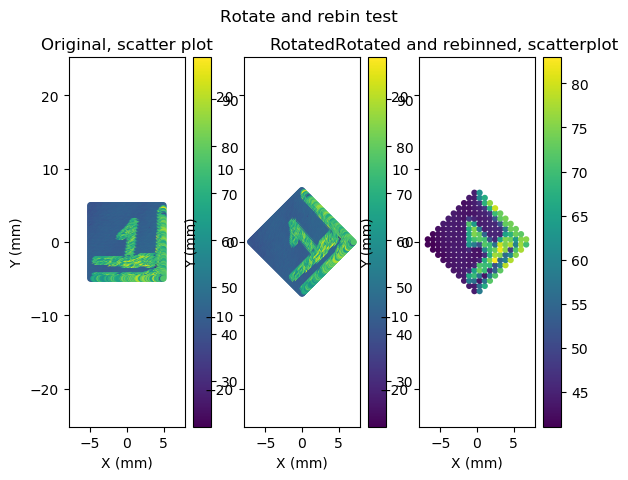

In [31]:
pts2=rotate_points(pts,45*np.pi/180)  #rotate 45 degrees
pts3=rebin_points(pts2,bins=nbins)

fig=plt.figure(8)
plt.clf()
plt.suptitle('Rotate and rebin test')
plt.subplot(131)
plt.title('Original, scatter plot')
plot_points(pts,scatter=1,aspect='equal')
ax1=plt.gca()
plt.subplot(132,sharex=ax1,sharey=ax1)
plt.title('Rotated')
plot_points(pts2,scatter=1,aspect='equal')
plt.subplot(133,sharex=ax1,sharey=ax1)
plt.title('Rotated and rebinned, scatterplot')
plot_points(pts3,scatter=1,aspect='equal')
plt.savefig(os.path.join(outfolder,'08_rotateandrebin.png'))
display(plt.gcf())

In [32]:
plt.close('all')